# Deep Learning Methodology

Desigining a model and input pipeline for the data

#### Import libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pymeanshift as pms
import csv
import random

from tensorflow import keras
from keras import layers

DATA_PATH = "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\image_paths.csv"
tf.config.list_physical_devices('GPU')

#### Shuffle

In [3]:
def shuffle_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)
        rows = list(reader)
    random.shuffle(rows)
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(rows)

shuffle_csv(DATA_PATH)

#### Dataset Creation

In [4]:
def load_image(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256], method='nearest')
    image = tf.image.convert_image_dtype(image, tf.float32)

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, [256, 256], method='nearest')
    label = tf.image.convert_image_dtype(label, tf.float32)

    return image, label

def load_dataset(csv_file):
    dataset = tf.data.experimental.CsvDataset(
        csv_file,
        [tf.string, tf.string],
        header=True,
        field_delim=','
    )
    dataset = dataset.map(load_image)
    return dataset

dataset = load_dataset(DATA_PATH)

#### Sanity Check

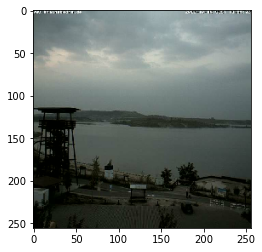

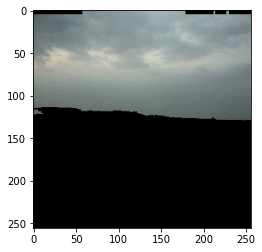

In [5]:
for image, label in dataset.take(1):
    image_masked = image * label # type: ignore
    plt.imshow(image)
    plt.show()
    plt.imshow(image_masked)
    plt.show()

#### Mean Shift Segmentation

In [6]:
def mean_shift(img, processing_shape=(256,256), spatial_radius=2, range_radius=8, min_density=150): 
    
    original_shape = img.shape
    img = cv2.resize(img, processing_shape)
    (segmented_image, labels_image, number_regions) = pms.segment(img, spatial_radius=spatial_radius, range_radius=range_radius, min_density=min_density)

    #take the upper half of labels_image and take the most dominant label in the upper half
    upper_labels = labels_image[0:labels_image.shape[0]//2, 0:labels_image.shape[1]]
    unique, counts = np.unique(upper_labels, return_counts=True)
    dominant_label = unique[np.argmax(counts)]

    #create a mask from labels_image where dominant_label is sky and resize it to original shape
    mask = np.zeros(labels_image.shape, dtype=np.uint8)
    mask[labels_image == dominant_label] = 1
    mask = cv2.resize(mask, (original_shape[1],original_shape[0]))

    return mask, segmented_image, labels_image

#### Model

In [9]:
def unet_model(input_shape=(256, 256, 3), output_channels=1):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Down-sampling through the model
    skips = []
    for filters in [64, 128, 256, 512]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        skips.append(x)
        x = layers.MaxPooling2D(2)(x)

    # Bottleneck
    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Up-sampling through the model
    for filters, skip in reversed(list(zip([512, 256, 128, 64], skips))):
        x = layers.UpSampling2D(2)(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    # Final layer
    outputs = layers.Conv2D(output_channels, 1)(x)
    outputs = layers.Activation('sigmoid')(outputs)

    return keras.Model(inputs=inputs, outputs=outputs)

# Create a UNET model
model = unet_model()

# Compile the model with loss and optimizer
model.compile(optimizer="adam", loss="binary_crossentropy")

# Define a callback to save the model after each epoch
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "models/model_epoch_{epoch}.h5", save_freq="epoch"
)

# Train the model on the dataset
model.fit(mini_dataset, epochs=1, callbacks=[checkpoint_callback])

10000/10000 [==============================] - 1336s 133ms/step - loss: 0.0690


#### Dataset Manipulation

In [ ]:
# Load your data into a tf.data.Dataset
mini_dataset = dataset.take(10000)

#add extra dimension to the dataset
mini_dataset = mini_dataset.map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))

#### Execution

In [19]:
# Create a UNET model
model = unet_model()

# Compile the model with loss and optimizer
model.compile(optimizer="adam", loss="binary_crossentropy")

# Define a callback to save the model after each epoch
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "models/model.h5", save_freq="epoch"
)

# Train the model on the dataset
model.fit(mini_dataset, epochs=10, callbacks=[checkpoint_callback])

Epoch 1/10
10000/10000 [==============================] - 1296s 129ms/step - loss: 0.0661
Epoch 2/10
10000/10000 [==============================] - 1316s 132ms/step - loss: 0.0284
Epoch 3/10
10000/10000 [==============================] - 1319s 132ms/step - loss: 0.0176
Epoch 4/10
10000/10000 [==============================] - 1318s 132ms/step - loss: 0.0129
Epoch 5/10
10000/10000 [==============================] - 1306s 131ms/step - loss: 0.0090
Epoch 6/10
10000/10000 [==============================] - 1308s 131ms/step - loss: 0.0074
Epoch 7/10
10000/10000 [==============================] - 1312s 131ms/step - loss: 0.0057
Epoch 8/10
10000/10000 [==============================] - 1310s 131ms/step - loss: 0.0044
Epoch 9/10
10000/10000 [==============================] - 1309s 131ms/step - loss: 0.0040
Epoch 10/10
10000/10000 [==============================] - 1312s 131ms/step - loss: 0.0030


#### Prediction

1/1 [==============================] - 0s 20ms/step


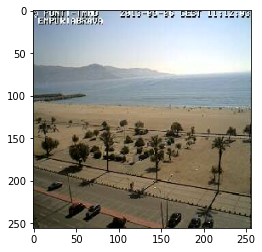

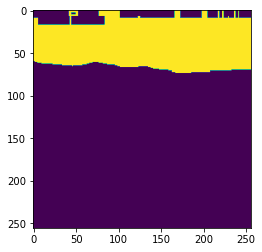

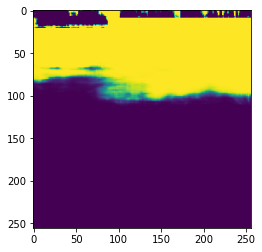

In [27]:
#predict on a single image from the dataset after skipping 10 images
for image, label in dataset.skip(7000).take(1):
    image = tf.expand_dims(image, axis=0)
    prediction = model.predict(image)

    plt.imshow(image[0])
    plt.show()
    plt.imshow(label)
    plt.show()
    plt.imshow(prediction[0])
    plt.show()

#### Real-World Check

In [14]:
from ipyfilechooser import FileChooser
# Create and display a FileChooser widget
fc = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset')
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset', filename='', title='', show_hidden=False…

1/1 [==============================] - 0s 19ms/step


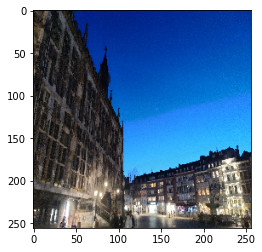

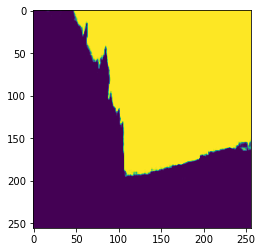

In [26]:
image = tf.io.read_file(fc.selected)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [256, 256], method='nearest')
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.expand_dims(image, axis=0)

prediction = model.predict(image)

plt.imshow(image[0])
plt.show()
plt.imshow(prediction[0])
plt.show()

### Trash

In [104]:
import tensorflow as tf
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv(DATA_PATH)

# Create a list to store the indices of corrupted rows
corrupted_indices = []

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Get the image path and label
    image_path = row['image_path']
    label_path = row['label']

    # Read the image and label files
    image_data = tf.io.read_file(image_path)
    label_data = tf.io.read_file(label_path)

    # Try to decode the image and label data
    try:
        image = tf.io.decode_jpeg(image_data)
        label = tf.io.decode_png(label_data)
        print(f'{image_path} and {label_path} are not corrupted')
    except:
        print(f'{image_path} or {label_path} are corrupted')
        corrupted_indices.append(index)

# Drop the rows containing corrupted paths from the DataFrame
df = df.drop(corrupted_indices)

# Write the updated DataFrame to a new CSV file
df.to_csv('updated.csv', index=False)

C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_084634.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted
C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_091628.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted
C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_114638.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted
C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_125725.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted
C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_154632.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted
